Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


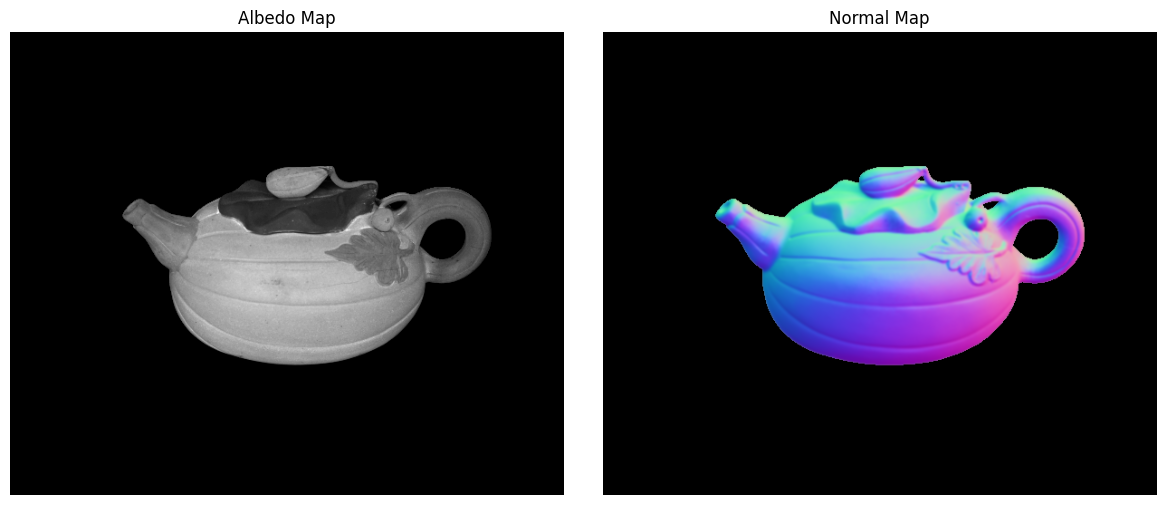

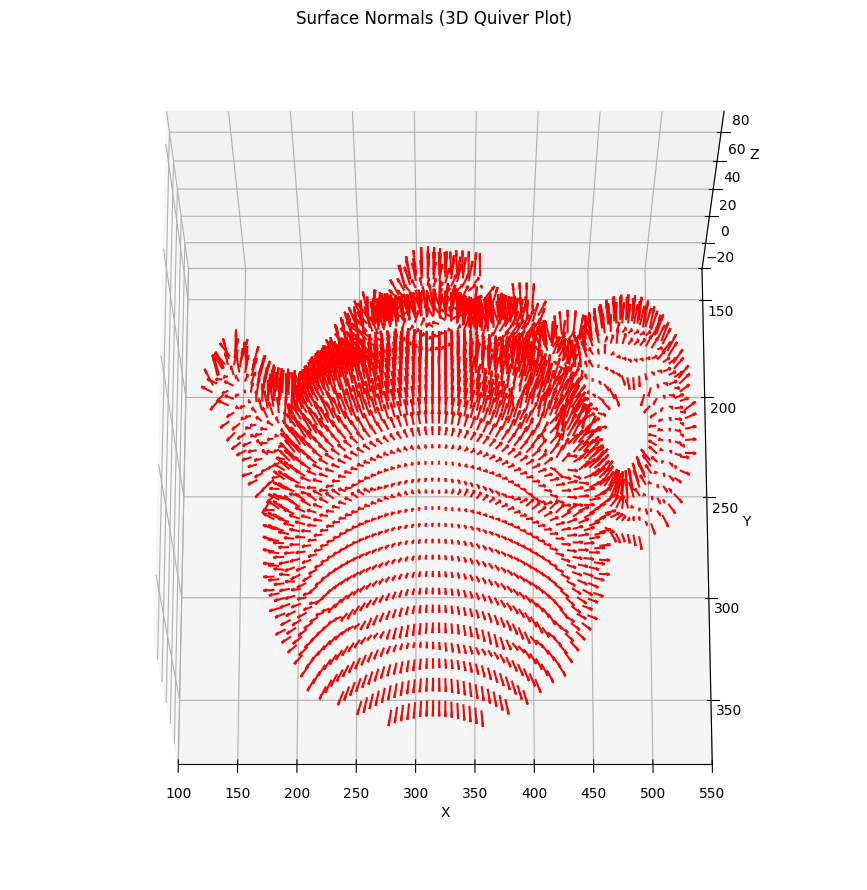

In [1]:
import cv2
import numpy as np
import os
import open3d as o3d
from numpy.fft import fft2, ifft2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def frankot_chellappa(p, q):
    h, w = p.shape
    wx = np.tile(np.fft.fftfreq(w), (h, 1))
    wy = np.tile(np.fft.fftfreq(h), (w, 1)).T

    Px = fft2(p)
    Qy = fft2(q)

    denom = (2 * np.pi * wx)**2 + (2 * np.pi * wy)**2
    denom[0, 0] = 1  # avoid division by zero

    Z = (-1j * 2 * np.pi * wx * Px - 1j * 2 * np.pi * wy * Qy) / denom
    z = np.real(ifft2(Z))
    return z

def depth_from_normals(normals, mask):
    nz = normals[:, :, 2]
    nz[nz == 0] = 1e-6

    p = -normals[:, :, 0] / nz
    q = -normals[:, :, 1] / nz

    p[~mask] = 0
    q[~mask] = 0

    depth = frankot_chellappa(p, q)
    return depth

def save_mesh(depth, normals, mask, filename):
    h, w = depth.shape
    xx, yy = np.meshgrid(np.arange(w), np.arange(h))
    points = np.stack((xx, yy, depth), axis=2).reshape(-1, 3)
    normals = normals.reshape(-1, 3)
    mask = mask.flatten()

    points = points[mask]
    normals = normals[mask]

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.normals = o3d.utility.Vector3dVector(normals)

    pcd.estimate_normals()
    pcd.orient_normals_consistent_tangent_plane(10)
    distances = pcd.compute_nearest_neighbor_distance()
    avg_dist = np.mean(distances)
    radius = 1.5 * avg_dist

    mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
        pcd, o3d.utility.DoubleVector([radius, radius * 2])
    )
    o3d.io.write_triangle_mesh(filename, mesh)

def estimate_normals(intensity_stack, light_dirs, mask):
    h, w, n = intensity_stack.shape
    I = intensity_stack.reshape(-1, n).T  # shape: (n, H*W)
    mask_flat = mask.flatten()

    # Only solve for pixels inside the mask
    I_masked = I[:, mask_flat]  # shape: (n, num_mask_pixels)
    L = light_dirs  # shape: (n, 3)

    L_pinv = np.linalg.pinv(L)
    G = L_pinv @ I_masked  # shape: (3, num_mask_pixels)

    norm = np.linalg.norm(G, axis=0) + 1e-6
    normals = G / norm  # shape: (3, num_mask_pixels)

    normal_map = np.zeros((h * w, 3), dtype=np.float32)
    normal_map[mask_flat] = normals.T
    normal_map = normal_map.reshape(h, w, 3)

    albedo = norm
    albedo_map = np.zeros((h * w,), dtype=np.float32)
    albedo_map[mask_flat] = albedo
    albedo_map = albedo_map.reshape(h, w)

    return normal_map, albedo_map

# ==== MAIN ====
image_folder = "./DiLiGenT/pmsData/pot1PNG"
n_images = 96

# Load mask
mask = cv2.imread(os.path.join(image_folder, "mask.png"), 0)
mask = (mask > 200)

# Load light directions and intensities
light_dirs = np.loadtxt(os.path.join(image_folder, "light_directions.txt"))  # (96, 3)
light_intensities = np.loadtxt(os.path.join(image_folder, "light_intensities.txt"))  # (96, 3)

# Load grayscale intensity images from RGB and normalize
intensity_images = []
for i in range(1, n_images + 1):
    img_path = os.path.join(image_folder, f"{i:03d}.png")
    rgb = cv2.imread(img_path).astype(np.float32) / 255.0  # shape: (H, W, 3)

    # Normalize each channel by corresponding light intensity
    light_intensity = light_intensities[i - 1]  # shape: (3,)
    norm_rgb = rgb / (light_intensity + 1e-6)  # avoid divide by zero

    # Convert to grayscale after normalization
    gray = 0.2989 * norm_rgb[:, :, 2] + 0.5870 * norm_rgb[:, :, 1] + 0.1140 * norm_rgb[:, :, 0]
    intensity_images.append(gray)

intensity_stack = np.stack(intensity_images, axis=-1)

# Estimate normals and albedo
normal_map, albedo_map = estimate_normals(intensity_stack, light_dirs, mask)
normal_mapk=normal_map
# Optional smoothing
normal_map = cv2.GaussianBlur(normal_map, (5, 5), 0)

# Visualization
normal_vis = (normal_map + 1) / 2.0
normal_vis[~mask] = 0

albedo_vis = albedo_map / (albedo_map.max() + 1e-6)
albedo_vis[~mask] = 0

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Albedo Map")
plt.imshow(albedo_vis, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Normal Map")
plt.imshow(normal_vis)
plt.axis('off')
plt.tight_layout()
plt.show()

# Flip for correct orientation
normal_map[:, :, 1] *= -1
normal_map[:, :, 2] *= -1

# Estimate depth
depth = depth_from_normals(normal_map, mask)
H, W = depth.shape

# Quiver plot of normals
X_coords, Y_coords = np.arange(W), np.arange(H)
X, Y = np.meshgrid(X_coords, Y_coords)

step = 5
X_plot = X[::step, ::step]
Y_plot = Y[::step, ::step]
Z_plot = -depth[::step, ::step]
Nx_plot = normal_map[::step, ::step, 0]
Ny_plot = normal_map[::step, ::step, 1]
Nz_plot = -normal_map[::step, ::step, 2]
mask_small = mask[::step, ::step]

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
ax.quiver(X_plot[mask_small], Y_plot[mask_small], Z_plot[mask_small],
          Nx_plot[mask_small], Ny_plot[mask_small], Nz_plot[mask_small],
          length=10.0, normalize=True, color='r')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Surface Normals (3D Quiver Plot)')
ax.view_init(elev=70, azim=90)
ax.set_xlim(550, 100)
plt.tight_layout()
plt.show()

# Save mesh
os.makedirs("./generated_mesh_from_light", exist_ok=True)
save_mesh(depth, normal_map, mask, "./generated_mesh_from_light/pot_mesh.ply")


#### Just too see the color albedo

(np.float64(-0.5), np.float64(611.5), np.float64(511.5), np.float64(-0.5))

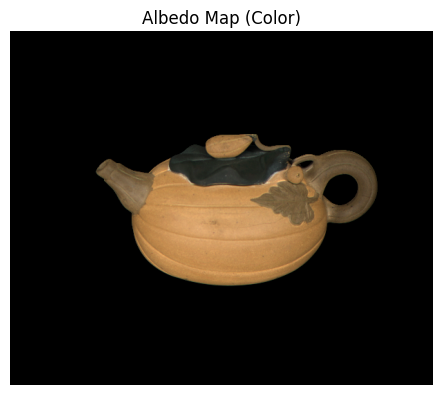

In [2]:
import cv2
import numpy as np
import os
import open3d as o3d
from numpy.fft import fft2, ifft2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def frankot_chellappa(p, q):
    h, w = p.shape
    wx = np.tile(np.fft.fftfreq(w), (h, 1))
    wy = np.tile(np.fft.fftfreq(h), (w, 1)).T

    Px = fft2(p)
    Qy = fft2(q)

    denom = (2 * np.pi * wx)**2 + (2 * np.pi * wy)**2
    denom[0, 0] = 1  

    Z = (-1j * 2 * np.pi * wx * Px - 1j * 2 * np.pi * wy * Qy) / denom
    z = np.real(ifft2(Z))
    return z

def depth_from_normals(normals, mask):
    nz = normals[:, :, 2]
    nz[nz == 0] = 1e-6

    p = -normals[:, :, 0] / nz
    q = -normals[:, :, 1] / nz

    p[~mask] = 0
    q[~mask] = 0

    depth = frankot_chellappa(p, q)
    return depth

def save_mesh(depth, normals, mask, filename):
    h, w = depth.shape
    xx, yy = np.meshgrid(np.arange(w), np.arange(h))
    points = np.stack((xx, yy, depth), axis=2).reshape(-1, 3)
    normals_flat = normals.reshape(-1, 3)
    mask_flat = mask.flatten()

    points = points[mask_flat]
    normals_flat = normals_flat[mask_flat]

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.normals = o3d.utility.Vector3dVector(normals_flat)

    pcd.estimate_normals()
    pcd.orient_normals_consistent_tangent_plane(10)
    distances = pcd.compute_nearest_neighbor_distance()
    avg_dist = np.mean(distances)
    radius = 1.5 * avg_dist

    mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
        pcd, o3d.utility.DoubleVector([radius, radius * 2])
    )
    o3d.io.write_triangle_mesh(filename, mesh)

def estimate_normals_and_albedo_color(intensity_stack_rgb, light_dirs, mask):
    h, w, n, c = intensity_stack_rgb.shape 
    I = intensity_stack_rgb.reshape(-1, n, c).transpose(1, 0, 2)  
    mask_flat = mask.flatten()

    L = light_dirs  # (n, 3)
    L_pinv = np.linalg.pinv(L)

    albedo_map = np.zeros((h * w, c), dtype=np.float32)
    normal_map = np.zeros((h * w, 3), dtype=np.float32)

    for ch in range(c):
        I_ch = I[:, :, ch]  
        I_masked = I_ch[:, mask_flat]  

        G = L_pinv @ I_masked  

        norm = np.linalg.norm(G, axis=0) + 1e-6
        normals = G / norm

        albedo_map[mask_flat, ch] = norm
        if ch == 0:
            normal_map[mask_flat, :] = normals.T

    normal_map = normal_map.reshape(h, w, 3)
    albedo_map = albedo_map.reshape(h, w, c)

    return normal_map, albedo_map



image_folder = "./DiLiGenT/pmsData/pot1PNG"
n_images = 96


mask = cv2.imread(os.path.join(image_folder, "mask.png"), 0)
mask = (mask > 200)


light_dirs = np.loadtxt(os.path.join(image_folder, "light_directions.txt"))  # (96, 3)
light_intensities = np.loadtxt(os.path.join(image_folder, "light_intensities.txt"))  # (96, 3)


intensity_images_rgb = []
for i in range(1, n_images + 1):
    img_path = os.path.join(image_folder, f"{i:03d}.png")
    rgb = cv2.imread(img_path).astype(np.float32) / 255.0 

    
    rgb = rgb[:, :, ::-1]

    light_intensity = light_intensities[i - 1]  
    norm_rgb = rgb / (light_intensity + 1e-6)  

    intensity_images_rgb.append(norm_rgb)


intensity_stack_rgb = np.stack(intensity_images_rgb, axis=-2)


normal_map, albedo_map = estimate_normals_and_albedo_color(intensity_stack_rgb, light_dirs, mask)


albedo_vis = albedo_map.copy()
albedo_vis[~mask] = 0
albedo_vis = albedo_vis / (albedo_vis.max() + 1e-6) 


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Albedo Map (Color)")
plt.imshow(albedo_vis)
plt.axis('off')



#### Angular error

In [3]:
# Load ground truth normals
normal_gt_path = os.path.join(image_folder, "normal.txt")
normal_gt = np.loadtxt(normal_gt_path)  # shape: (H*W, 3)
normal_gt = normal_gt.reshape(mask.shape[0], mask.shape[1], 3)  # reshape to (H, W, 3)
# # normal_gt[:, :, 0] *= -1
# normal_gt[:, :, 1] *= -1
# normal_gt[:, :, 2] *= -1


# Normalize predicted and ground-truth normals
norm_pred = normal_mapk / (np.linalg.norm(normal_mapk, axis=2, keepdims=True) + 1e-6)
norm_gt = normal_gt / (np.linalg.norm(normal_gt, axis=2, keepdims=True) + 1e-6)

# Dot product per pixel
dot_product = np.sum(norm_pred * norm_gt, axis=2)
dot_product = np.clip(dot_product, -1.0, 1.0)  # Clamp for safety

# Angular error in degrees
angular_error = np.arccos(dot_product) * (180.0 / np.pi)

# Mask out background
angular_error[~mask] = np.nan

mean_angular_error = np.nanmean(angular_error)
print(f"Mean Angular Error: {mean_angular_error:.2f} degrees")


Mean Angular Error: 10.03 degrees


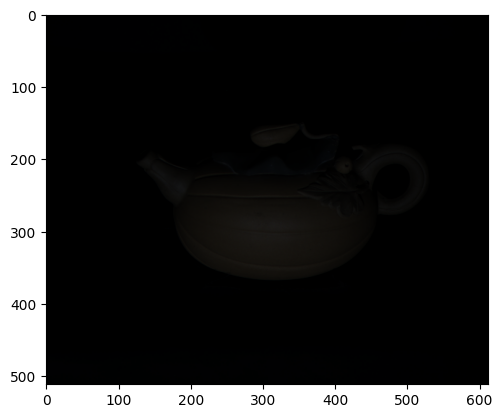

In [4]:
import matplotlib.pyplot as plt
color_img_path = os.path.join(image_folder, "./001.png")
color_img = cv2.imread(color_img_path)
color_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
plt.imshow(color_img)

In [5]:
color_img = color_img.astype(np.float32) / 255.0  # Normalize to [0, 1]
colors = color_img.reshape(-1, 3)
colors = colors[mask.flatten()]


In [6]:
def save_mesh(depth, normals, mask, filename, colors=None):
    h, w = depth.shape
    xx, yy = np.meshgrid(np.arange(w), np.arange(h))
    points = np.stack((xx, yy, depth), axis=2).reshape(-1, 3)
    normals = normals.reshape(-1, 3)
    mask = mask.flatten()

    points = points[mask]
    normals = normals[mask]

    # Create point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.normals = o3d.utility.Vector3dVector(normals)
    
    if colors is not None:
        pcd.colors = o3d.utility.Vector3dVector(colors)

    # Ball pivoting for mesh
    pcd.estimate_normals()
    pcd.orient_normals_consistent_tangent_plane(10)
    distances = pcd.compute_nearest_neighbor_distance()
    avg_dist = np.mean(distances)
    radius = 2 * avg_dist

    mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
        pcd, o3d.utility.DoubleVector([radius, radius * 2])
    )

    o3d.io.write_triangle_mesh(filename, mesh)


In [7]:
save_mesh(depth, normal_map, mask, "./generated_mesh_from_light/pot_colored_mesh.ply", colors=colors)


#### Mesh
![Mesh Animation.gif](./generated_mesh_from_light/ImageToStl.com_pot_mesh+(8).ply.gif)


#### Mesh Color
![Mesh Animation.gif](./generated_mesh_from_light/ImageToStl.com_pot_colored_mesh+(1).ply.gif)



#### Another object

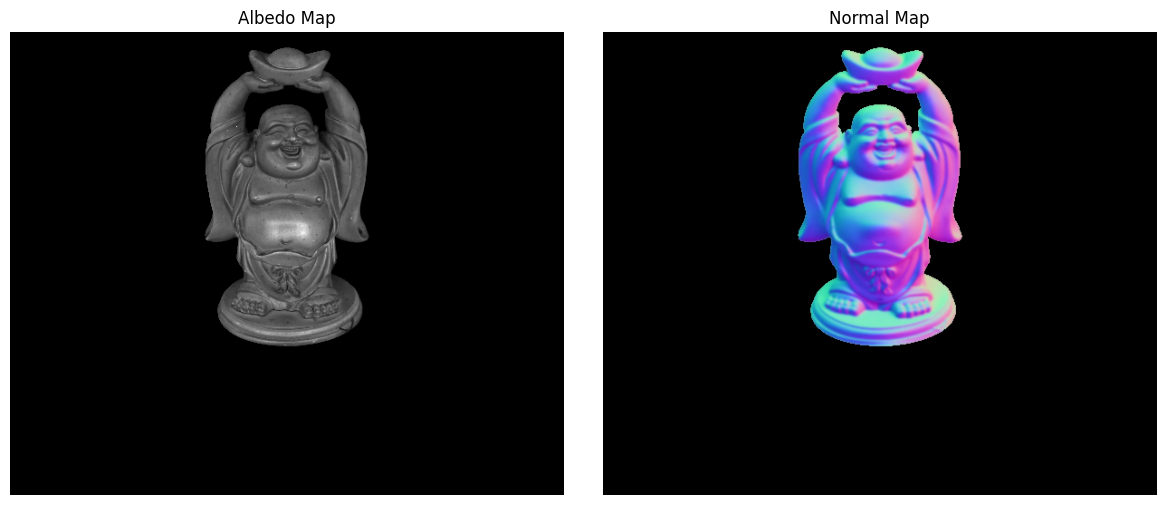

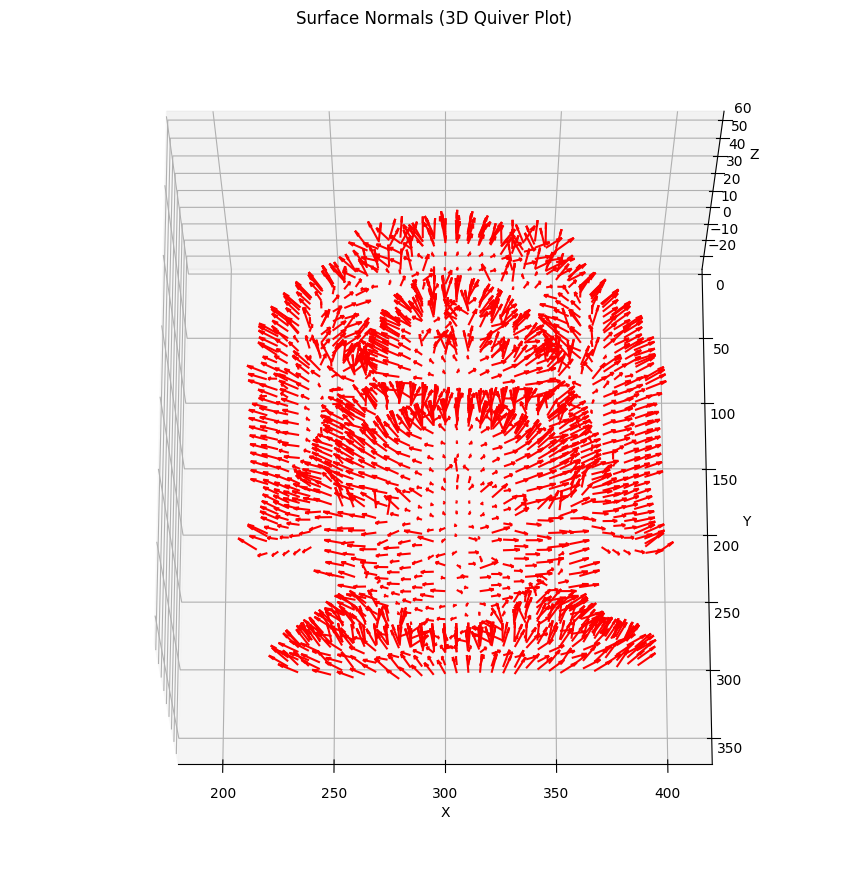

In [8]:
import cv2
import numpy as np
import os
import open3d as o3d
from numpy.fft import fft2, ifft2

def frankot_chellappa(p, q):
    h, w = p.shape
    wx = np.tile(np.fft.fftfreq(w), (h, 1))
    wy = np.tile(np.fft.fftfreq(h), (w, 1)).T

    Px = fft2(p)
    Qy = fft2(q)

    denom = (2 * np.pi * wx) ** 2 + (2 * np.pi * wy) ** 2
    denom[0, 0] = 1  # avoid divide by zero

    Z = (-1j * 2 * np.pi * wx * Px - 1j * 2 * np.pi * wy * Qy) / denom
    z = np.real(ifft2(Z))
    return z

def depth_from_normals(normals, mask):
    nz = normals[:, :, 2]
    nz[nz == 0] = 1e-6

    p = -normals[:, :, 0] / nz
    q = -normals[:, :, 1] / nz

    p[~mask] = 0
    q[~mask] = 0

    depth = frankot_chellappa(p, q)
    return depth

def save_mesh(depth, normals, mask, filename):
    h, w = depth.shape
    xx, yy = np.meshgrid(np.arange(w), np.arange(h))
    points = np.stack((xx, yy, depth), axis=2).reshape(-1, 3)
    normals = normals.reshape(-1, 3)
    mask = mask.flatten()

    points = points[mask]
    normals = normals[mask]

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.normals = o3d.utility.Vector3dVector(normals)

    pcd.estimate_normals()
    pcd.orient_normals_consistent_tangent_plane(10)
    distances = pcd.compute_nearest_neighbor_distance()
    avg_dist = np.mean(distances)
    radius = 1.5 * avg_dist

    mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
        pcd, o3d.utility.DoubleVector([radius, radius * 2])
    )
    o3d.io.write_triangle_mesh(filename, mesh)

def estimate_normals(intensity_stack, light_dirs, mask):
    h, w, n = intensity_stack.shape
    I = intensity_stack.reshape(-1, n).T  # shape: (n, H*W)
    mask_flat = mask.flatten()

    # Only solve for pixels inside the mask
    I_masked = I[:, mask_flat]  # shape: (n, num_mask_pixels)
    L = light_dirs  # shape: (n, 3)

    # Solve least squares: I = L @ (rho * N)^T --> G = L⁺ I
    L_pinv = np.linalg.pinv(L)
    G = L_pinv @ I_masked  # shape: (3, num_mask_pixels)

    # Compute normals and albedo
    norm = np.linalg.norm(G, axis=0) + 1e-6
    normals = G / norm  # shape: (3, num_mask_pixels)

    # Create full-size normal map
    normal_map = np.zeros((h * w, 3), dtype=np.float32)
    normal_map[mask_flat] = normals.T
    normal_map = normal_map.reshape(h, w, 3)

    
    albedo = norm
    albedo_map = np.zeros((h * w,), dtype=np.float32)
    albedo_map[mask_flat] = albedo
    albedo_map = albedo_map.reshape(h, w)

    return normal_map, albedo_map



# ==== MAIN ====
# Set paths
image_folder = "./DiLiGenT/pmsData/buddhaPNG/"
n_images = 96  # DiLiGenT has 96 images per object

# Load mask
mask = cv2.imread(os.path.join(image_folder, "mask.png"), 0)
mask = (mask > 0)

# Load light directions and intensities
light_dirs = np.loadtxt(os.path.join(image_folder, "light_directions.txt"))  # (96, 3)
light_intensities = np.loadtxt(os.path.join(image_folder, "light_intensities.txt"))  # (96, 3)

# Load grayscale intensity images from RGB and normalize
intensity_images = []
for i in range(1, n_images + 1):
    img_path = os.path.join(image_folder, f"{i:03d}.png")
    rgb = cv2.imread(img_path).astype(np.float32) / 255.0  # shape: (H, W, 3)

    # Normalize each channel by corresponding light intensity
    light_intensity = light_intensities[i - 1]  # shape: (3,)
    norm_rgb = rgb / (light_intensity + 1e-6)  # avoid divide by zero

    # Convert to grayscale after normalization
    gray = 0.2989 * norm_rgb[:, :, 2] + 0.5870 * norm_rgb[:, :, 1] + 0.1140 * norm_rgb[:, :, 0]
    intensity_images.append(gray)

intensity_stack = np.stack(intensity_images, axis=-1)

# Estimate normals
normal_map, albedo_map = estimate_normals(intensity_stack, light_dirs, mask)
normal_mapk=normal_map
# Optional: Gaussian smooth
normal_map = cv2.GaussianBlur(normal_map, (5, 5), 0)



import matplotlib.pyplot as plt

# Normalize normal map for visualization (range [0, 1])
normal_vis = (normal_map + 1) / 2.0
normal_vis[~mask] = 0

# Normalize albedo for visualization
albedo_vis = albedo_map.copy()
#albedo_vis -= albedo_vis.min()
albedo_vis /= albedo_vis.max() + 1e-6
albedo_vis[~mask] = 0

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Albedo Map")
plt.imshow(albedo_vis, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Normal Map")
plt.imshow(normal_vis)
plt.axis('off')

plt.tight_layout()
plt.show()


normal_map[:, :, 1] *= -1



import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D





# Estimate depth
depth = depth_from_normals(normal_map, mask)


# Extract height and width
H, W = depth.shape

# Extract normals
Nx = normal_map[:, :, 0]
Ny = normal_map[:, :, 1]
Nz = normal_map[:, :, 2]

# Create grid of (X,Y) pixel coordinates
X_coords = np.arange(W)
Y_coords = np.arange(H)
X, Y = np.meshgrid(X_coords, Y_coords)

# Downsample for clarity
step = 5  # Adjust for quiver density
X_plot = X[::step, ::step]
Y_plot = Y[::step, ::step]
Z_plot = depth[::step, ::step]
Nx_plot = Nx[::step, ::step]
Ny_plot = Ny[::step, ::step]
Nz_plot = Nz[::step, ::step]



# Apply mask to remove background points
mask_small = mask[::step, ::step]
X_plot = X_plot[mask_small]
Y_plot = Y_plot[mask_small]
Z_plot = Z_plot[mask_small]
Nx_plot = Nx_plot[mask_small]
Ny_plot = Ny_plot[mask_small]
Nz_plot = Nz_plot[mask_small]

# Create 3D quiver plot
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
ax.quiver(X_plot, Y_plot, Z_plot, Nx_plot, Ny_plot, Nz_plot,
          length=10.0, normalize=True, color='r')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Surface Normals (3D Quiver Plot)')
ax.view_init(elev=70, azim=90)
ax.set_xlim(420,180)
plt.tight_layout()
plt.show()

# Save mesh
os.makedirs("./generated_mesh_from_light", exist_ok=True)
save_mesh(depth, normal_map, mask, "./generated_mesh_from_light/buddha_mesh.ply")


(np.float64(-0.5), np.float64(611.5), np.float64(511.5), np.float64(-0.5))

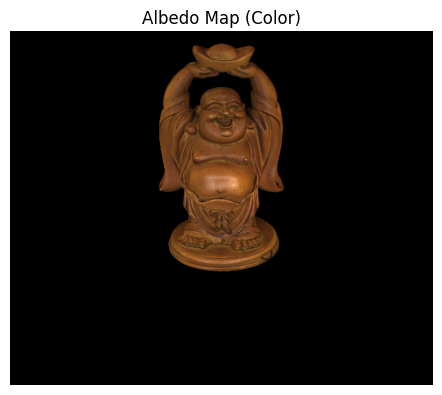

In [10]:
import cv2
import numpy as np
import os
import open3d as o3d
from numpy.fft import fft2, ifft2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def frankot_chellappa(p, q):
    h, w = p.shape
    wx = np.tile(np.fft.fftfreq(w), (h, 1))
    wy = np.tile(np.fft.fftfreq(h), (w, 1)).T

    Px = fft2(p)
    Qy = fft2(q)

    denom = (2 * np.pi * wx)**2 + (2 * np.pi * wy)**2
    denom[0, 0] = 1  

    Z = (-1j * 2 * np.pi * wx * Px - 1j * 2 * np.pi * wy * Qy) / denom
    z = np.real(ifft2(Z))
    return z

def depth_from_normals(normals, mask):
    nz = normals[:, :, 2]
    nz[nz == 0] = 1e-6

    p = -normals[:, :, 0] / nz
    q = -normals[:, :, 1] / nz

    p[~mask] = 0
    q[~mask] = 0

    depth = frankot_chellappa(p, q)
    return depth

def save_mesh(depth, normals, mask, filename):
    h, w = depth.shape
    xx, yy = np.meshgrid(np.arange(w), np.arange(h))
    points = np.stack((xx, yy, depth), axis=2).reshape(-1, 3)
    normals_flat = normals.reshape(-1, 3)
    mask_flat = mask.flatten()

    points = points[mask_flat]
    normals_flat = normals_flat[mask_flat]

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.normals = o3d.utility.Vector3dVector(normals_flat)

    pcd.estimate_normals()
    pcd.orient_normals_consistent_tangent_plane(10)
    distances = pcd.compute_nearest_neighbor_distance()
    avg_dist = np.mean(distances)
    radius = 1.5 * avg_dist

    mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
        pcd, o3d.utility.DoubleVector([radius, radius * 2])
    )
    o3d.io.write_triangle_mesh(filename, mesh)

def estimate_normals_and_albedo_color(intensity_stack_rgb, light_dirs, mask):
    h, w, n, c = intensity_stack_rgb.shape 
    I = intensity_stack_rgb.reshape(-1, n, c).transpose(1, 0, 2)  # shape: (n, H*W, 3)
    mask_flat = mask.flatten()

    L = light_dirs  # (n, 3)
    L_pinv = np.linalg.pinv(L)

    albedo_map = np.zeros((h * w, c), dtype=np.float32)
    normal_map = np.zeros((h * w, 3), dtype=np.float32)

    for ch in range(c):
        I_ch = I[:, :, ch] 
        I_masked = I_ch[:, mask_flat]  

        G = L_pinv @ I_masked  

        norm = np.linalg.norm(G, axis=0) + 1e-6
        normals = G / norm

        albedo_map[mask_flat, ch] = norm
        if ch == 0:
            normal_map[mask_flat, :] = normals.T

    normal_map = normal_map.reshape(h, w, 3)
    albedo_map = albedo_map.reshape(h, w, c)

    return normal_map, albedo_map


image_folder = "./DiLiGenT/pmsData/buddhaPNG/"
n_images = 96


mask = cv2.imread(os.path.join(image_folder, "mask.png"), 0)
mask = (mask > 200)

light_dirs = np.loadtxt(os.path.join(image_folder, "light_directions.txt"))  # (96, 3)
light_intensities = np.loadtxt(os.path.join(image_folder, "light_intensities.txt"))  # (96, 3)

intensity_images_rgb = []
for i in range(1, n_images + 1):
    img_path = os.path.join(image_folder, f"{i:03d}.png")
    rgb = cv2.imread(img_path).astype(np.float32) / 255.0  

    rgb = rgb[:, :, ::-1]

    light_intensity = light_intensities[i - 1] 
    norm_rgb = rgb / (light_intensity + 1e-6)  

    intensity_images_rgb.append(norm_rgb)


intensity_stack_rgb = np.stack(intensity_images_rgb, axis=-2)


normal_map, albedo_map = estimate_normals_and_albedo_color(intensity_stack_rgb, light_dirs, mask)



albedo_vis = albedo_map.copy()
albedo_vis[~mask] = 0
albedo_vis = albedo_vis / (albedo_vis.max() + 1e-6)  


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Albedo Map (Color)")
plt.imshow(albedo_vis)
plt.axis('off')



#### Angular Error

In [11]:
# Load ground truth normals
normal_gt_path = os.path.join(image_folder, "normal.txt")
normal_gt = np.loadtxt(normal_gt_path)  # shape: (H*W, 3)
normal_gt = normal_gt.reshape(mask.shape[0], mask.shape[1], 3)  # reshape to (H, W, 3)



# Normalize predicted and ground-truth normals
norm_pred = normal_mapk / (np.linalg.norm(normal_mapk, axis=2, keepdims=True) + 1e-6)
norm_gt = normal_gt / (np.linalg.norm(normal_gt, axis=2, keepdims=True) + 1e-6)

# Dot product per pixel
dot_product = np.sum(norm_pred * norm_gt, axis=2)
dot_product = np.clip(dot_product, -1.0, 1.0)  # Clamp for safety

# Angular error in degrees
angular_error = np.arccos(dot_product) * (180.0 / np.pi)

# Mask out background
angular_error[~mask] = np.nan

mean_angular_error = np.nanmean(angular_error)
print(f"Mean Angular Error: {mean_angular_error:.2f} degrees")


Mean Angular Error: 15.28 degrees


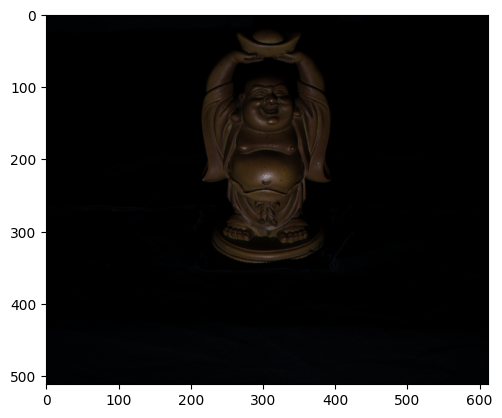

In [12]:
color_img_path = os.path.join(image_folder, "./001.png")
color_img = cv2.imread(color_img_path)
color_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
plt.imshow(color_img)

In [13]:
color_img = color_img.astype(np.float32) / 255.0  # Normalize to [0, 1]
colors = color_img.reshape(-1, 3)
colors = colors[mask.flatten()]


In [14]:
def save_mesh(depth, normals, mask, filename, colors=None):
    h, w = depth.shape
    xx, yy = np.meshgrid(np.arange(w), np.arange(h))
    points = np.stack((xx, yy, depth), axis=2).reshape(-1, 3)
    normals = normals.reshape(-1, 3)
    mask = mask.flatten()

    points = points[mask]
    normals = normals[mask]

    # Create point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.normals = o3d.utility.Vector3dVector(normals)
    
    if colors is not None:
        pcd.colors = o3d.utility.Vector3dVector(colors)

    # Ball pivoting for mesh
    pcd.estimate_normals()
    pcd.orient_normals_consistent_tangent_plane(10)
    distances = pcd.compute_nearest_neighbor_distance()
    avg_dist = np.mean(distances)
    radius = 1.5 * avg_dist

    mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
        pcd, o3d.utility.DoubleVector([radius, radius * 2])
    )

    o3d.io.write_triangle_mesh(filename, mesh)


In [15]:
save_mesh(depth, normal_map, mask, "./generated_mesh_from_light/buddha_colored_mesh.ply", colors=colors)


#### Mesh
![Mesh Animation.gif](./generated_mesh_from_light/ImageToStl.com_buddha_mesh+(4).ply.gif)


#### Mesh Color
![Mesh Animation.gif](./generated_mesh_from_light/ImageToStl.com_buddha_colored_mesh+(2).ply.gif)
